In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm.notebook import tqdm

from datasets import load_dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

from bert_utils import TextSentiment, compute_centers_cov, mahalanobis_score, metrics_eval

imdb = load_dataset('imdb')
yelp = load_dataset("yelp_polarity")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')

trainset = TextSentiment(imdb['train'], tokenizer)
ID = TextSentiment(imdb['test'], tokenizer)
OOD = TextSentiment(yelp['test'], tokenizer)

batch_size = 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
ID_loader = torch.utils.data.DataLoader(ID, batch_size=batch_size,shuffle=True, num_workers=2)
OOD_loader = torch.utils.data.DataLoader(OOD, batch_size=batch_size,shuffle=True, num_workers=2)

model = torch.hub.load('huggingface/pytorch-transformers',
                       'modelForSequenceClassification', 
                       'bert-base-cased',
                       output_attentions=False).cuda()
#model = torch.load('./models/bert/IMDB_finetuned10')

Reusing dataset imdb (/home/jupyter/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)
Reusing dataset yelp_polarity (/home/jupyter/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/2b33212d89209ed1ea0522001bccc5f5a5c920dd9c326f3c828e67a22c51a98c)
Using cache found in /home/jupyter/.cache/torch/hub/huggingface_pytorch-transformers_master
Using cache found in /home/jupyter/.cache/torch/hub/huggingface_pytorch-transformers_master
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the ch

In [ ]:
# First computing class centers and covariance matrices

model.eval()

start_layer = 0
layers = 13 # Number of layers
num_classes = 2
num_per_class = None

centers_cov_matrices = [compute_centers_cov(trainloader, model, layer, num_classes,
                                            num_per_class, quantity_target=None)
                        for layer in range(start_layer,layers)]

In [ ]:
# Computing the inverses of covariance matrices. It may be necessary to manually change the value of eps

eps = 0.0000001 # This tiny quantity added to all covariance matrices is here to prevent divisions by zero
                # from happening
try:
    inv_cov_matrices = [torch.inverse(S+eps*torch.ones(S.size()).cuda()) for _, S in centers_cov_matrices]
except RuntimeError:
    eps = eps * 1.05

In [ ]:
# Building score dataset for logistic regression training

X = []
y = []

quantity_target = 5000 # 

for data_in, data_out in tqdm(zip(ID_loader,OOD_loader)):
    
    txt_in, txt_out = data_in['input_ids'].cuda(), data_out['input_ids'].cuda()
    
    features_in = np.zeros((len(txt_in),layers-start_layer))
    features_out = np.zeros((len(txt_out),layers-start_layer))
    
    for k in range(0, layers-start_layer):
        
        centers, _ = centers_cov_matrices[k]
        inv_cov_matrix = inv_cov_matrices[k]
        
        scores_in = mahalanobis_score(txt_in, model, centers, inv_cov_matrix, layer=start_layer+k)
        scores_out = mahalanobis_score(txt_out, model, centers, inv_cov_matrix, layer=start_layer+k)
        
        features_in[:,k] = scores_in.cpu().numpy()
        features_out[:,k] = scores_out.cpu().numpy()
        
    X = X + list(features_in) + list(features_out)
    y = y + [0]*len(scores_in) + [1]*len(scores_out)
    
    if len(y) >= quantity_target:
        break

np.save(f'./data/scores_IMDB_Yelp_{len(y)}',X)
np.save(f'./data/labels_IMDB_Yelp_{len(y)}',y)

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

load_data = True # This flag is used to either load from disk or from memory.

if load_data:
    X = np.load(f'./data/scores_IMDB_Yelp_5000.npy')
    y = np.load(f'./data/labels_IMDB_Yelp_5000.npy')
    layers = 13
    start_layer = 0
else:
    X = np.array(X)
    y = np.array(y)
    
for k in range(layers-start_layer):
    X[:,k] = X[:,k]/max(X[:,k].max(), -X[:,k].min()) # Normalizing Mahalanobis scores

y = 1-y # Inverting ID/OOD convention so that the LR's coefficients are positive

X_train, X_test, y_train, y_test = train_test_split(np.array(X),y, test_size=0.5, shuffle=True)

LR = LogisticRegression(max_iter=200000, verbose=0, fit_intercept=False)
LR.fit(X_train[:,1:],y_train)

y_pred = LR.predict_proba(X_test[:,1:])[:,1]


# Converting results to the format used in the metrics_eval function
for l in range(layers):
    scores_ID, scores_OOD = [], []
    for k in range(len(y_test)):
        if not y_test[k]:
            scores_OOD.append(X_test[k,l])
        else:
            scores_ID.append(X_test[k,l])
        
    print(f'layer {l}')
    print(roc_auc_score(y_test,X_test[:,l]))
    print(metrics_eval(scores_ID, scores_OOD))

scores_ID, scores_OOD = [], []
for k in range(len(y_test)):
    if not y_test[k]:
        scores_OOD.append(y_pred[k])
    else:
        scores_ID.append(y_pred[k])

print('\nAll layers logistic Regression')
print(metrics_eval(scores_ID, scores_OOD))

layer 0
0.5
{'auroc': -0.0, 'auprIN': 29.856134510190106, 'auprOUT': 31.5250327984636, 'detection accuracy': 50.0, 'tnr at 95 tpr': 0.0}
layer 1
0.9091781061371993
{'auroc': 90.91781061371995, 'auprIN': 91.96986247859621, 'auprOUT': 89.67054833162481, 'detection accuracy': 84.03392686891996, 'tnr at 95 tpr': 48.31636648394675}
layer 2
0.9484060083072358
{'auroc': 94.84060083072357, 'auprIN': 95.66162989511476, 'auprOUT': 93.82085021915283, 'detection accuracy': 88.57306865090978, 'tnr at 95 tpr': 67.42364917776038}
layer 3
0.9620795878525085
{'auroc': 96.20795878525085, 'auprIN': 97.02555204269537, 'auprOUT': 95.02661309443121, 'detection accuracy': 91.76703882963635, 'tnr at 95 tpr': 76.11589663273297}
layer 4
0.9488868726593078
{'auroc': 94.8886872659308, 'auprIN': 95.87248539928626, 'auprOUT': 93.62058184082966, 'detection accuracy': 89.56860512840872, 'tnr at 95 tpr': 65.54424432263117}
layer 5
0.9329876147015153
{'auroc': 93.29876147015153, 'auprIN': 94.6079212286858, 'auprOUT': 9

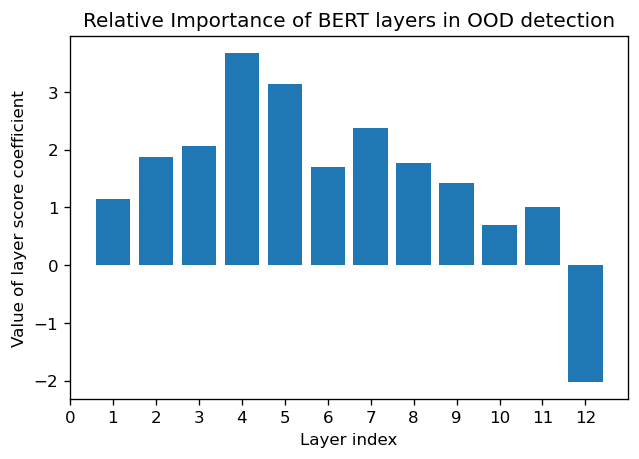

In [3]:
import matplotlib.pyplot as plt
plt.figure(dpi=120)
plt.bar(range(1,13),LR.coef_[0])
plt.title('Relative Importance of BERT layers in OOD detection')
plt.xlabel('Layer index')
plt.ylabel('Value of layer score coefficient')
plt.xticks(range(13))
plt.show()

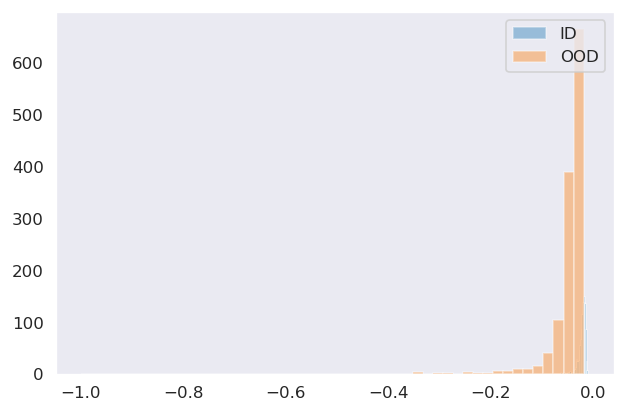

In [5]:
# This cell can be used to visualize the score distributions at a specific layer

import seaborn as sns
import matplotlib.pyplot as plt

l = 4 # Index of layer

scores_ID, scores_OOD = [], []
for k in range(len(y_test)):
    if not y_test[k]:
        scores_OOD.append(X_test[k,l])
    else:
        scores_ID.append(X_test[k,l])
        
plt.figure(dpi=120)
sns.set_style('dark')
sns.distplot(scores_ID, hist = True, kde = False, kde_kws = {'linewidth': 2}, label='ID')
sns.distplot(scores_OOD, hist = True, kde = False, kde_kws = {'linewidth': 2}, label='OOD')
plt.legend(loc='upper right')
plt.show()